# Transport Network
This code is made for the final proyect of FAIKR - Module 3.
Authors:
- Luca Trambaiollo
- Álvaro Esteban Muñoz

## Libraries & Functions

In [1]:
# Always important to add
import numpy as np
import matplotlib.pyplot as plt

# Library for plotting the graph of the network
import daft
from daft import PGM

# Pgmpy to define bayesian networks
from pgmpy.models import BayesianNetwork
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

By default, when printing CPDs, those are truncated, we define a function that changes that parameter temporaly to print the fully table.

In [2]:
def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

## Graph of the network
Here is defined the graph of the bayesian network implemented for the proyect.

### Definition of the variables
The network is composed by the following discrete variables:
- **Age (A)**: the age, recorded as young (young) for individuals below 30 years old, adult (adult) for individuals between 30 and 60 years old, and old (old) for people older than 60.
- **Sex (S)**: the biological sex of the individual, recorded as male (M) or female (F).
- **Education (E)**: the highest level of education or training completed by the individual, recorded either as up to high school (high) or university degree (uni).
- **Occupation (O)**: whether the individual is an employee (emp) or a self- employed (self) worker.
- **Residence (R)**: the size of the city the individual lives in, recorded as either small (small) or big (big).
- **Travel (T)**: the means of transport favoured by the individual, recorded either as car (car), train (train) or other (foot, bicycle).

### Graph of the original network
The following graph is the design of the original network taken from the book: *"Bayesian Network With Examples in R"* by Marco Scutari & Jean-Baptiste Denis

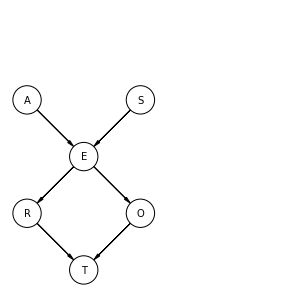

In [3]:
pgm = PGM(shape=[5, 5])

# Add the nodes to the net graph
pgm.add_node(daft.Node("A", r"A", 1, 5))
pgm.add_node(daft.Node("S", r"S", 3, 5))
pgm.add_node(daft.Node("E", r"E", 2, 4))
pgm.add_node(daft.Node("O", r"O", 3, 3))
pgm.add_node(daft.Node("R", r"R", 1, 3))
pgm.add_node(daft.Node("T", r"T", 2, 2))

# Add the edgest to the net graph
pgm.add_edge("A", "E")
pgm.add_edge("S", "E")
pgm.add_edge("E", "R")
pgm.add_edge("E", "O")
pgm.add_edge("O", "T")
pgm.add_edge("R", "T")

pgm.render()
plt.show()

### Graph of the new Network
We added four new variables to make the network more interesting:
- **Field of Work (F)**: the possible fields of work are divided into Scientific (Sci), Humanistic (Hum), Artistic (Art) and Social (Soc).
- **Working Style (W)**: according to the new situation caused by the Covid the style of work can be smart working (sm) (which include also the possibility of the hybrid style)or in office (of).
- **Distance (D)**: the distance to reach the workplace is recorded as near (n) if it is between 0 (when you work from home) and 25 km,  or far(f) if it is more than 10 km.
- **Pollution (P)**: the level of the pollution in the air, recorded as low (low), medium (med) and high (high). 

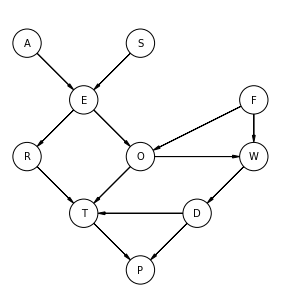

In [4]:
pgm = PGM(shape=[5, 5])

# Add the nodes to the net graph
pgm.add_node(daft.Node("A", r"A", 1, 5))
pgm.add_node(daft.Node("S", r"S", 3, 5))
pgm.add_node(daft.Node("E", r"E", 2, 4))
pgm.add_node(daft.Node("O", r"O", 3, 3))
pgm.add_node(daft.Node("R", r"R", 1, 3))
pgm.add_node(daft.Node("T", r"T", 2, 2))
pgm.add_node(daft.Node("F", r"F", 5, 4))
pgm.add_node(daft.Node("W", r"W", 5, 3))
pgm.add_node(daft.Node("D", r"D", 4, 2))
pgm.add_node(daft.Node("P", r"P", 3, 1))

# Add the edgest to the net graph
pgm.add_edge("A", "E")
pgm.add_edge("S", "E")
pgm.add_edge("E", "R")
pgm.add_edge("E", "O")
pgm.add_edge("F", "O")
pgm.add_edge("F", "W")
pgm.add_edge("O", "T")
pgm.add_edge("O", "W")
pgm.add_edge("R", "T")
pgm.add_edge("W", "D")
pgm.add_edge("D", "T")
pgm.add_edge("D", "P")
pgm.add_edge("T", "P")

pgm.render()
plt.show()

## Implementation of the network

In [5]:
# DEFINITION OF VARIABLES
A = "Age"
S = "Sex"
E = "Education"
O = "Occupation"
R = "Residence"
T = "Travel"

F = "Field"
W = "Working Style"
D = "Distance"
P = "Pollution"

# DEFINITION OF THE NETWORK STRUCTURE
#   Definition of the edges
education_model = BayesianNetwork([(A,E),(S,E),(E,O),(E,R),(F,O),(F,W),(O,T),(O,W),(W,D),(R,T),(D,T),(T,P),(D,P)])

#   Define the Cumulative Probability Distribution (CPD) tables
age_cpd=TabularCPD(A,3,[[.5],
                        [.2],
                        [.3]],
                        state_names={A: ["adult", "old", "young"]})

sex_cpd=TabularCPD(S,2,[[.4],
                        [.6]],
                        state_names={S: ["female", "male"]})

edu_cpd=TabularCPD(E,2,[[.7,.9,.64,.72,.88,.75],
                        [.3,.1,.36,.28,.12,.25]],
                        evidence=[S,A],evidence_card=[2,3],
                        state_names={E: ["high", "uni"], S: ["female", "male"], A: ["adult", "old", "young"]})

res_cpd=TabularCPD(R,2,[[.75,.8],
                        [.25,.2]],
                        evidence=[E],evidence_card=[2],
                        state_names={R: ["big", "small"], E: ["high", "uni"]})

fie_cpd=TabularCPD(F,4,[[.09],
                        [.22],
                        [.38],
                        [.31]],
                        state_names={F: ["Artistic", "Humanistic", "Scientific", "Social"]})

ocu_cpd=TabularCPD(O,2,[[.65,.90,.80,.86,.61,.86,.76,.82],
                        [.35,.10,.20,.14,.39,.14,.24,.18],],
                        evidence=[E,F], evidence_card=[2,4],
                        state_names={O: ["emp", "self"], E: ["high", "uni"], F: ["Artistic", "Humanistic", "Scientific", "Social"]})

wor_cpd=TabularCPD(W,2,[[.31,.83,.48,.78,.04,.17,.10,.15],
                        [.69,.17,.52,.22,.96,.83,.90,.85]],
                        evidence=[O,F], evidence_card=[2,4],
                        state_names={W: ["off", "sw"], O: ["emp", "self"], F: ["Artistic", "Humanistic", "Scientific", "Social"]})

dis_cpd=TabularCPD(D,2,[[.35,.06],
                        [.65,.94]],
                        evidence=[W], evidence_card=[2],
                        state_names={D: ["far", "near"], W: ["off", "sw"]})

tra_cpd=TabularCPD(T,3,[[.58,.55,.60,.15,.48,.45,.53,.10],
                        [.09,.39,.08,.84,.10,.47,.09,.88],
                        [.33,.06,.32,.01,.42,.08,.38,.02]],
                        evidence=[O,R,D], evidence_card=[2,2,2],
                        state_names={T: ["car", "other", "train"], R: ["big", "small"], O: ["emp", "self"], D: ["far", "near"]})

pol_cpd=TabularCPD(P,3,[[.85,0,.6,.63,0,.13],
                        [.02,1,.13,.07,1,.25],
                        [.13,0,.27,.3,0,.62]],
                        evidence=[D,T], evidence_card=[2,3],
                        state_names={P: ["high", "low", "medium"], D: ["far", "near"], T: ["car", "other", "train"]})

#   Add the CPD tables to the network
education_model.add_cpds(age_cpd,sex_cpd,edu_cpd,ocu_cpd,fie_cpd,res_cpd,wor_cpd,dis_cpd,tra_cpd,pol_cpd)

In [6]:
# Check if the network is well defined
education_model.check_model()

True

In [7]:
# SHOW THE CPD TABLES
print("CPD Tables:")
print("Age:")
print_full(age_cpd)
print("\nSex:")
print_full(sex_cpd) 
print("\nEducation:")
print_full(edu_cpd) 
print("\nResidence:")
print_full(res_cpd)
print("\Field of working:")
print_full(fie_cpd)
print("\Working style:")
print_full(wor_cpd)
print("\nOcupation:")
print_full(ocu_cpd)
print("\nTravel:")
print_full(tra_cpd)
print("\distance:")
print_full(dis_cpd)
print("\nPollution:")
print_full(pol_cpd)

CPD Tables:
Age:
+------------+-----+
| Age(adult) | 0.5 |
+------------+-----+
| Age(old)   | 0.2 |
+------------+-----+
| Age(young) | 0.3 |
+------------+-----+

Sex:
+-------------+-----+
| Sex(female) | 0.4 |
+-------------+-----+
| Sex(male)   | 0.6 |
+-------------+-----+

Education:
+-----------------+-------------+-------------+-------------+------------+-----------+------------+
| Sex             | Sex(female) | Sex(female) | Sex(female) | Sex(male)  | Sex(male) | Sex(male)  |
+-----------------+-------------+-------------+-------------+------------+-----------+------------+
| Age             | Age(adult)  | Age(old)    | Age(young)  | Age(adult) | Age(old)  | Age(young) |
+-----------------+-------------+-------------+-------------+------------+-----------+------------+
| Education(high) | 0.7         | 0.9         | 0.64        | 0.72       | 0.88      | 0.75       |
+-----------------+-------------+-------------+-------------+------------+-----------+------------+
| Educat

## Sample queries

In [8]:
# We will use exact inference by variable elimination
education_inference = VariableElimination(education_model)

### Query 01
**Causal:** to compare the pollution level probabilities we have performed two queries where we have defined the pollution as query variable while the evidence variable changes between ’smart working’ and ’office’.

$P (P |W ), W ∈ [sw, off]$

In [9]:
pol_prob_sw = education_inference.query(variables=[P], evidence={W: "sw"})
pol_prob_off = education_inference.query(variables=[P], evidence={W: "off"})

print("P(P|W=sw):")
print_full(pol_prob_sw)
print("\nP(P|W=off):")
print_full(pol_prob_off)

P(P|W=sw):
+-------------------+------------------+
| Pollution         |   phi(Pollution) |
+===================+==================+
| Pollution(high)   |           0.2984 |
+-------------------+------------------+
| Pollution(low)    |           0.5404 |
+-------------------+------------------+
| Pollution(medium) |           0.1613 |
+-------------------+------------------+

P(P|W=off):
+-------------------+------------------+
| Pollution         |   phi(Pollution) |
+===================+==================+
| Pollution(high)   |           0.4315 |
+-------------------+------------------+
| Pollution(low)    |           0.4031 |
+-------------------+------------------+
| Pollution(medium) |           0.1654 |
+-------------------+------------------+


We can notice there is a huge different between the probabilities polluting for a person who does smart working  and a person who works at the office.

- $(P(P="high"|W="sw")=0.2984)$
- $(P(P="high"|W="off")=0.4315)$

### Query 02
**Causal:** we have generated one query for each group of age in order to understand which is the generation that has a higher probability to pollute more.

$P (P |A), A ∈ [young, adult, old]$

In [10]:
pol_young = education_inference.query(variables=[P], evidence={A: "young"})
pol_adult = education_inference.query(variables=[P], evidence={A: "adult"})
pol_old = education_inference.query(variables=[P], evidence={A: "old"})

print("P(P|A=young):\n", pol_young, "\n")
print("P(P|A=adult):\n", pol_adult, "\n")
print("P(P|A=old):\n", pol_old, "\n")

P(P|A=young):
 +-------------------+------------------+
| Pollution         |   phi(Pollution) |
+===================+==================+
| Pollution(high)   |           0.3718 |
+-------------------+------------------+
| Pollution(low)    |           0.4644 |
+-------------------+------------------+
| Pollution(medium) |           0.1638 |
+-------------------+------------------+ 

P(P|A=adult):
 +-------------------+------------------+
| Pollution         |   phi(Pollution) |
+===================+==================+
| Pollution(high)   |           0.3718 |
+-------------------+------------------+
| Pollution(low)    |           0.4645 |
+-------------------+------------------+
| Pollution(medium) |           0.1637 |
+-------------------+------------------+ 

P(P|A=old):
 +-------------------+------------------+
| Pollution         |   phi(Pollution) |
+===================+==================+
| Pollution(high)   |           0.3708 |
+-------------------+------------------+
| Pollutio

In this case we can see the difference between the probability of pollution among the generations is not high enough to assume any conclusions.

### Query 03
**Evidential:** to explain which is the field of work that is more conscious about the pollution we have run three queries each one with a different level of pollution.

$P(F|P), P ∈ [high, medium, low]$

In [11]:
field_prob1 = education_inference.query(variables=[F], evidence={P: "high"})
field_prob2 = education_inference.query(variables=[F], evidence={P: "medium"})
field_prob3 = education_inference.query(variables=[F], evidence={P: "low"})

print("P(F|P=high):")
print(field_prob1)
print("\nP(F|P=medium):")
print(field_prob2)
print("\nP(F|P=low):")
print(field_prob3)

P(F|P=high):
+-------------------+--------------+
| Field             |   phi(Field) |
+===================+==============+
| Field(Artistic)   |       0.0783 |
+-------------------+--------------+
| Field(Humanistic) |       0.2365 |
+-------------------+--------------+
| Field(Scientific) |       0.3607 |
+-------------------+--------------+
| Field(Social)     |       0.3245 |
+-------------------+--------------+

P(F|P=medium):
+-------------------+--------------+
| Field             |   phi(Field) |
+===================+==============+
| Field(Artistic)   |       0.0887 |
+-------------------+--------------+
| Field(Humanistic) |       0.2212 |
+-------------------+--------------+
| Field(Scientific) |       0.3793 |
+-------------------+--------------+
| Field(Social)     |       0.3108 |
+-------------------+--------------+

P(F|P=low):
+-------------------+--------------+
| Field             |   phi(Field) |
+===================+==============+
| Field(Artistic)   |       0.099

For this query is interesting to underline that the lower the level of pollution the lower the probability of belonging to the scientific or artistic field.

### Query 04
**Intercausal:** we have defined two differents queries to justify the relation between the residence and the working style.

$P (R|W ), W ∈ [sw, off]$

In [12]:
res_prob_sw = education_inference.query(variables=[R], evidence={W: "sw"})
res_prob_off = education_inference.query(variables=[R], evidence={W: "off"})

print("P(R|W=sw):")
print(res_prob_sw)
print("\nP(R|W=off):")
print(res_prob_off)

P(R|W=sw):
+------------------+------------------+
| Residence        |   phi(Residence) |
+==================+==================+
| Residence(big)   |           0.7632 |
+------------------+------------------+
| Residence(small) |           0.2368 |
+------------------+------------------+

P(R|W=off):
+------------------+------------------+
| Residence        |   phi(Residence) |
+==================+==================+
| Residence(big)   |           0.7624 |
+------------------+------------------+
| Residence(small) |           0.2376 |
+------------------+------------------+


the difference between the probability of having a big residence being a person that does a smart working in respect to a person that works in the office is 0,8%.

## Approximation of the CPD Tables

In [13]:
# Generation of data
datasets = []
n_vector = [1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6, 5e6, 1e7]

# Define a dataset for each size
for n in n_vector:
    datasets.append(BayesianModelSampling(education_model).forward_sample(size=int(n)))

# Example of a dataset
datasets[0].head()

Generating for node: Pollution: 100%|██████████| 10/10 [01:59<00:00, 11.93s/it]   


,Age,Education,Sex,Occupation,Residence,Field,Working Style,Travel,Distance,Pollution
0,adult,uni,female,emp,big,Social,off,car,near,high
1,adult,high,female,emp,big,Scientific,off,other,near,low
2,young,high,female,self,big,Social,sw,car,near,high
3,adult,uni,male,emp,small,Scientific,off,other,near,low
4,adult,high,female,emp,big,Scientific,sw,other,near,low


In [14]:
# Define the bayesian estimator
best = BayesianEstimator(model=education_model, data=datasets[0])

# We only estimate the CPD table of the last node
est = best.estimate_cpd(node=P)
print_full(pol_cpd) # Original CPD Table
print_full(est)     # Estimated CPD Table

+-------------------+---------------+---------------+---------------+----------------+----------------+----------------+
| Distance          | Distance(far) | Distance(far) | Distance(far) | Distance(near) | Distance(near) | Distance(near) |
+-------------------+---------------+---------------+---------------+----------------+----------------+----------------+
| Travel            | Travel(car)   | Travel(other) | Travel(train) | Travel(car)    | Travel(other)  | Travel(train)  |
+-------------------+---------------+---------------+---------------+----------------+----------------+----------------+
| Pollution(high)   | 0.85          | 0.0           | 0.6           | 0.63           | 0.0            | 0.13           |
+-------------------+---------------+---------------+---------------+----------------+----------------+----------------+
| Pollution(low)    | 0.02          | 1.0           | 0.13          | 0.07           | 1.0            | 0.25           |
+-------------------+-----------

In [15]:
# Compute the error using the 2-norm error
error = []
for i in range(len(datasets)):
    best = BayesianEstimator(model=education_model, data=datasets[i])
    est = best.estimate_cpd(node=P)
    error.append(np.linalg.norm(pol_cpd.values - est.values))

In [16]:
print(error)    # Error vector

[0.17809311904454225, 0.07706402205754558, 0.032013300848409955, 0.027148376012395052, 0.016998825964282052, 0.004675686387981411, 0.005231841981053398, 0.003078939781962725, 0.0011198120201135248]


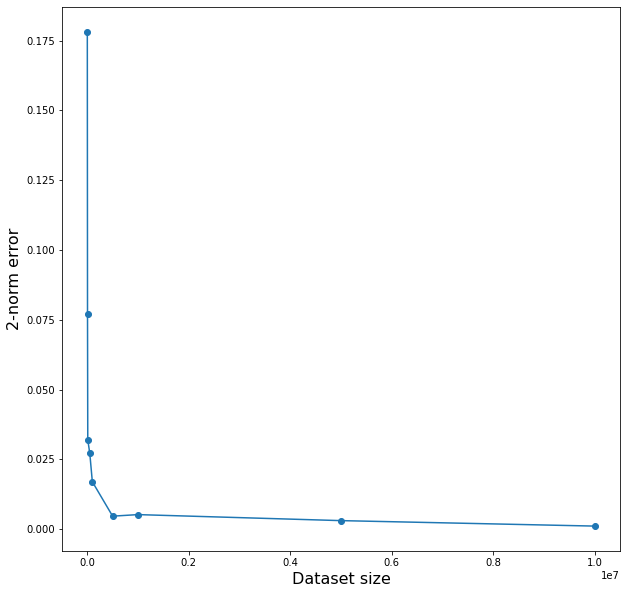

In [17]:
# Plot results
plt.figure(figsize=(10,10))
plt.xlabel("Dataset size", fontsize=16)
plt.ylabel("2-norm error", fontsize=16)
plt.plot(n_vector, error, marker='o')
plt.show()